In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from jcopml.time_series.decomposition import stl_decomposition
from jcopml.time_series import auto_ets

from pmdarima import auto_arima

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data 

In [2]:
df = pd.read_csv("electricity_data_US_only.csv", index_col="Date", parse_dates=["Date"])
df.head()

,United States : all sectors,United States : electric utility,United States : independent power producers,United States : all commercial,United States : all industrial
Date,,,,,
2001-01-01,332493,236467,82269,629,13128
2001-02-01,282940,199802,71169,548,11421
2001-03-01,300707,211942,75758,553,12454
2001-04-01,278079,197499,68356,550,11674
2001-05-01,300492,215508,72658,575,11751


In [3]:
df.index

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01'],
              dtype='datetime64[ns]', name='Date', length=255, freq=None)

# Exploratory Data Analysis 

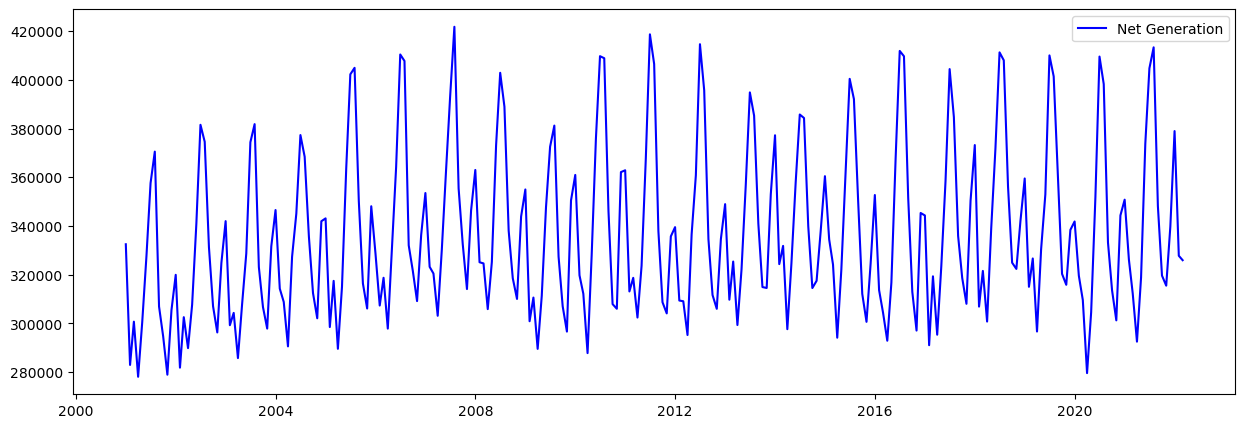

In [4]:
plt.figure(figsize=(15,5))
plt.plot(df['United States : all sectors'], 'b-', label='Net Generation')
plt.legend()

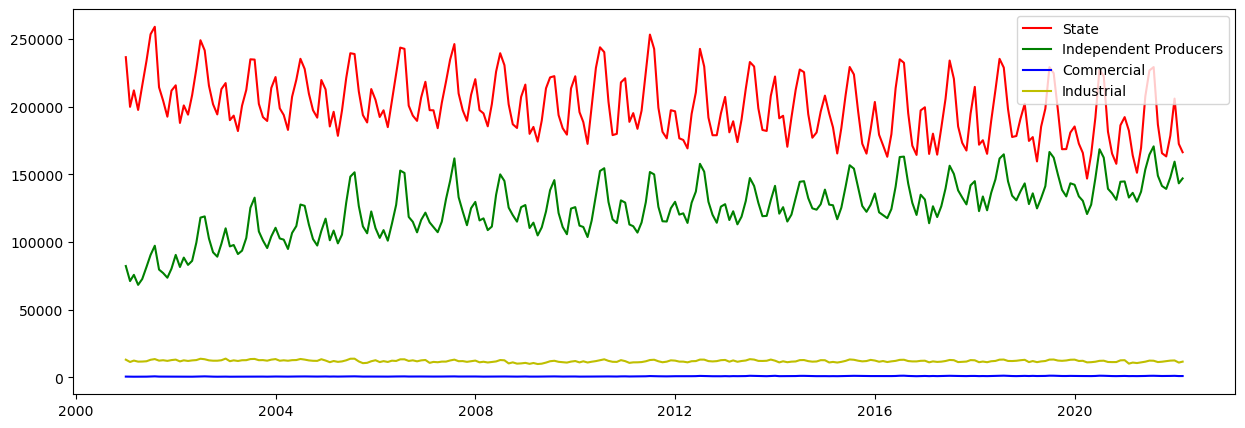

In [5]:
plt.figure(figsize=(15,5))
plt.plot(df['United States : electric utility'], 'r-', label='State')
plt.plot(df['United States : independent power producers'], 'g-', label='Independent Producers')
plt.plot(df['United States : all commercial'], 'b-', label='Commercial')
plt.plot(df['United States : all industrial'], 'y-', label='Industrial')
plt.legend()

# Feature Engineering 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255 entries, 2001-01-01 to 2022-03-01
Data columns (total 5 columns):
 #   Column                                       Non-Null Count  Dtype
---  ------                                       --------------  -----
 0   United States : all sectors                  255 non-null    int64
 1   United States : electric utility             255 non-null    int64
 2   United States : independent power producers  255 non-null    int64
 3   United States : all commercial               255 non-null    int64
 4   United States : all industrial               255 non-null    int64
dtypes: int64(5)
memory usage: 12.0 KB


In [7]:
df['united_states_all_sectors'] = df['United States : all sectors']
df.drop(columns=['United States : electric utility', 'United States : independent power producers',
                 'United States : all commercial', 'United States : all industrial', 'United States : all sectors'], inplace=True)
df.head()

,united_states_all_sectors
Date,
2001-01-01,332493
2001-02-01,282940
2001-03-01,300707
2001-04-01,278079
2001-05-01,300492


# Forecasting 

<Axes: xlabel='Date'>

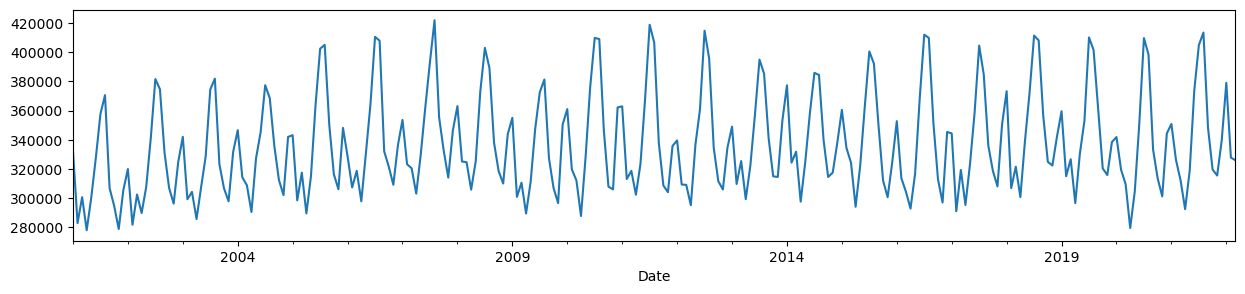

In [8]:
series = df.united_states_all_sectors
X_train, X_test = series[:-25], series[-25:]
series.plot(figsize=(15,3))

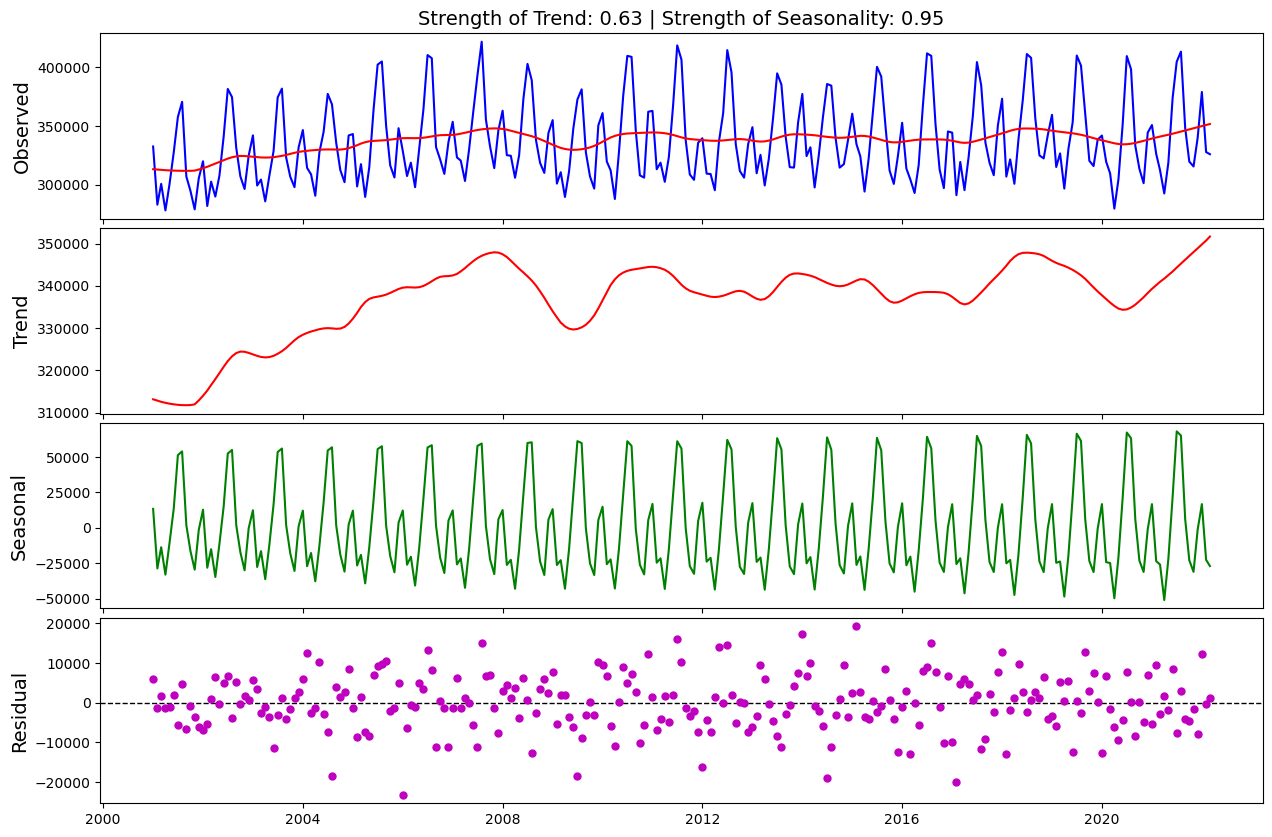

In [9]:
stl_decomposition(df.united_states_all_sectors, plot=True)

## With ARIMA

In [10]:
arima = auto_arima(X_train, seasonal=True, m=4, information_criterion='aicc', trace=True, suppress_warnings=True, random_state=42)

Performing stepwise search to minimize aicc
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AICC=inf, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AICC=5395.604, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AICC=5383.795, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AICC=5376.251, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AICC=5393.572, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AICC=5394.963, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AICC=5373.308, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AICC=5383.805, Time=0.04 sec
 ARIMA(0,1,1)(2,0,1)[4] intercept   : AICC=5294.802, Time=0.12 sec
 ARIMA(0,1,1)(2,0,0)[4] intercept   : AICC=5339.347, Time=0.11 sec
 ARIMA(0,1,1)(2,0,2)[4] intercept   : AICC=5252.037, Time=0.61 sec
 ARIMA(0,1,1)(1,0,2)[4] intercept   : AICC=5337.492, Time=0.22 sec
 ARIMA(0,1,0)(2,0,2)[4] intercept   : AICC=5253.359, Time=0.45 sec
 ARIMA(1,1,1)(2,0,2)[4] intercept   : AICC=5238.150, Time=1.05 sec
 ARIMA(1,1,1)(1,0,2)[4]

In [11]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  230
Model:             SARIMAX(3, 1, 0)x(2, 0, [1, 2], 4)   Log Likelihood               -2585.951
Date:                                Sun, 15 Oct 2023   AIC                           5187.902
Time:                                        09:00:55   BIC                           5215.372
Sample:                                             0   HQIC                          5198.984
                                                - 230                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1602      0.124     -1.288      0.198      -0.404       0.084
ar.L2         -0.1281      0.074     -1.726      0.084      -0.274       0.017
ar.L3         -0.1746      0.080     -2.172      0.030      -0.332      -0.017
ar.S.L4       -0.9764      0.027    -36.810      0.000      -1.028      -0.924
ar.S.L8       -0.9857      0.024    -40.288      0.000      -1.034      -0.938
ma.S.L4        0.9435      0.075     12.663      0.000       0.797       1.090
ma.S.L8        0.9102      0.080     11.335      0.000       0.753       1.068
sigma2      6.438e+08   1.56e-11   4.14e+19      0.000    6.44e+08    6.44e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.93   Prob(JB):                         0.95
Heteroskedasticity (H):               0.44   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.46e+36. Standard errors may be unstable.
"""

In [12]:
n_forecast = len(X_test)+20
pred = arima.predict(n_forecast)

dates = pd.date_range(X_train.index[-1], periods=n_forecast, freq='M')
pred = pd.Series(pred, index=dates)

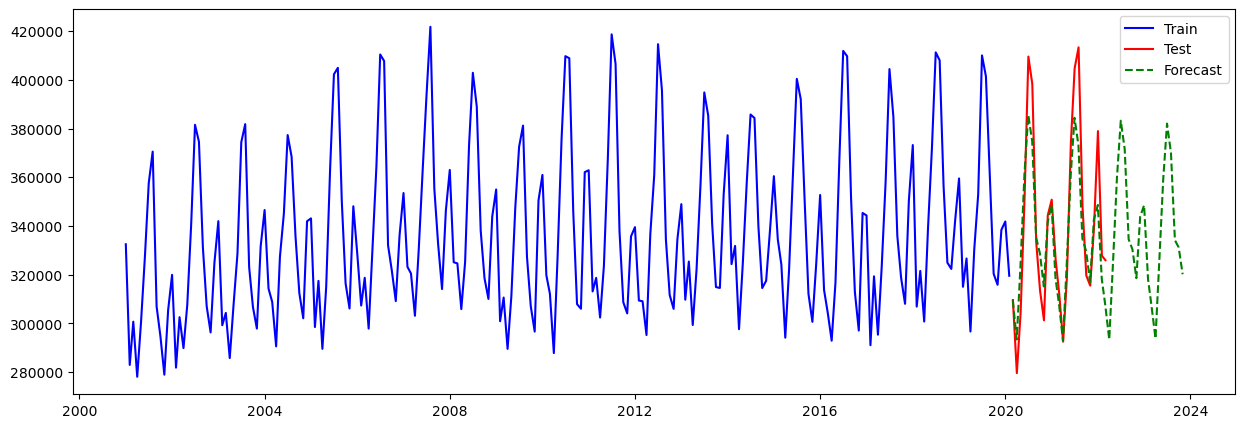

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(X_train, 'b-', label='Train')
plt.plot(X_test, 'r-', label='Test')
plt.plot(pred, 'g--', label='Forecast')
plt.legend()

# With LSTM 

In [14]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import normaltest

In [15]:
normaltest(df.united_states_all_sectors)

NormaltestResult(statistic=19.12835404369296, pvalue=7.019896280870144e-05)

In [16]:
values = df.united_states_all_sectors.values
values = values.reshape(len(values), 1)

In [17]:
scaler = StandardScaler()
scaler = scaler.fit(values)

In [18]:
df.united_states_all_sectors = scaler.transform(values)
df.united_states_all_sectors

Date
2001-01-01   -0.125149
2001-02-01   -1.573316
2001-03-01   -1.054083
2001-04-01   -1.715377
2001-05-01   -1.060366
                ...   
2021-11-01   -0.621909
2021-12-01    0.085005
2022-01-01    1.233035
2022-02-01   -0.263265
2022-03-01   -0.316307
Name: united_states_all_sectors, Length: 255, dtype: float64

## Dataset Splitting 

In [19]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((204, 1), (51, 1))

## Dataset & Dataloader 

In [20]:
seq_len = 12
bs = 16

train_set = TimeSeriesDataset(ts_train, "united_states_all_sectors", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "united_states_all_sectors", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (16, 12, 1)
Note: last 11 data excluded

(N, S, F): (4, 12, 1)
Note: last 2 data excluded



## Arsitektur & Config

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [22]:
config = set_config({
    'input_size': train_set.n_feature,
    'output_size': 1,
    'hidden_size': 8,
    'num_layers': 2,
    'dropout': 0.001,
    'seq_len': train_set.n_seq
})

## Training Preparation 

In [23]:
model = LSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/lstm1")

## Training

In [24]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1.0273 | Test_cost  = 1.2650 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 1.0254 | Test_cost  = 1.2618 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 1.0236 | Test_cost  = 1.2587 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 1.0217 | Test_cost  = 1.2557 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 1.0201 | Test_cost  = 1.2527 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 1.0184 | Test_cost  = 1.2498 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 1.0168 | Test_cost  = 1.2470 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 1.0152 | Test_cost  = 1.2442 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 1.0136 | Test_cost  = 1.2414 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 1.0121 | Test_cost  = 1.2387 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 1.0106 | Test_cost  = 1.2361 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 1.0092 | Test_cost  = 1.2334 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 1.0077 | Test_cost  = 1.2308 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 1.0062 | Test_cost  = 1.2282 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 1.0049 | Test_cost  = 1.2256 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 1.0035 | Test_cost  = 1.2231 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 1.0021 | Test_cost  = 1.2205 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 1.0008 | Test_cost  = 1.2180 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.9994 | Test_cost  = 1.2154 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.9980 | Test_cost  = 1.2128 | 


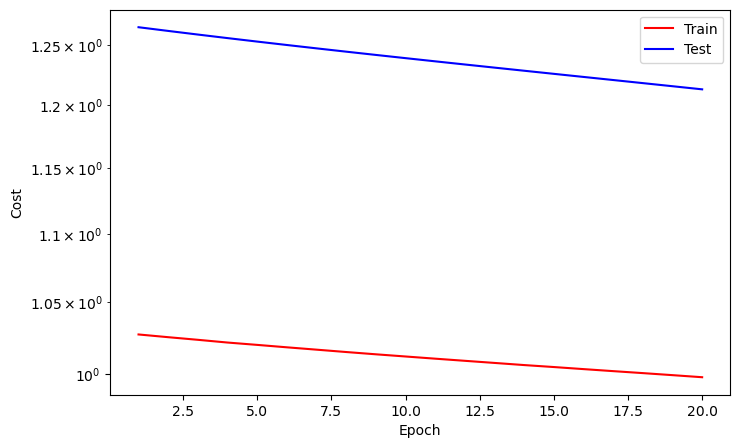

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.9967 | Test_cost  = 1.2103 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.9954 | Test_cost  = 1.2077 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.9940 | Test_cost  = 1.2051 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.9927 | Test_cost  = 1.2025 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.9913 | Test_cost  = 1.1998 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.9902 | Test_cost  = 1.1971 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.9886 | Test_cost  = 1.1944 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.9871 | Test_cost  = 1.1917 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.9858 | Test_cost  = 1.1889 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.9844 | Test_cost  = 1.1860 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.9829 | Test_cost  = 1.1831 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.9815 | Test_cost  = 1.1802 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.9800 | Test_cost  = 1.1772 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.9785 | Test_cost  = 1.1742 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.9770 | Test_cost  = 1.1711 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.9755 | Test_cost  = 1.1679 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.9739 | Test_cost  = 1.1646 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.9724 | Test_cost  = 1.1613 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.9708 | Test_cost  = 1.1580 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.9692 | Test_cost  = 1.1545 | 


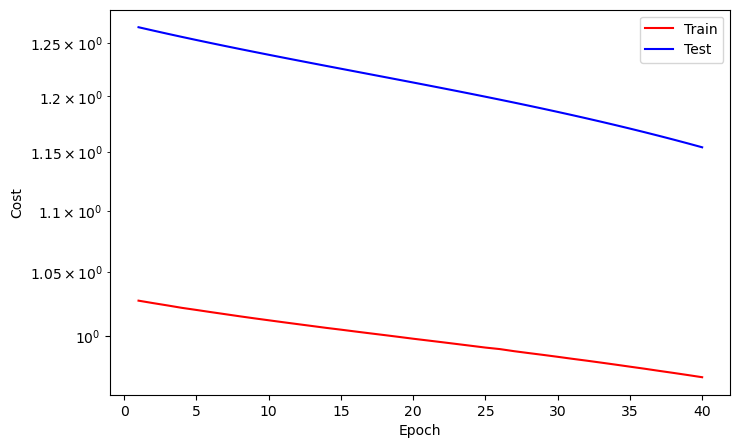

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.9675 | Test_cost  = 1.1510 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.9658 | Test_cost  = 1.1473 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.9641 | Test_cost  = 1.1436 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 0.9624 | Test_cost  = 1.1398 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 0.9607 | Test_cost  = 1.1359 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 0.9589 | Test_cost  = 1.1320 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 0.9571 | Test_cost  = 1.1279 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 0.9553 | Test_cost  = 1.1237 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 0.9534 | Test_cost  = 1.1194 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 0.9518 | Test_cost  = 1.1150 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 0.9497 | Test_cost  = 1.1105 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 0.9478 | Test_cost  = 1.1059 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 0.9459 | Test_cost  = 1.1012 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 0.9440 | Test_cost  = 1.0964 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 0.9421 | Test_cost  = 1.0915 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 0.9403 | Test_cost  = 1.0864 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 0.9383 | Test_cost  = 1.0813 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 0.9364 | Test_cost  = 1.0762 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 0.9346 | Test_cost  = 1.0709 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 0.9328 | Test_cost  = 1.0656 | 


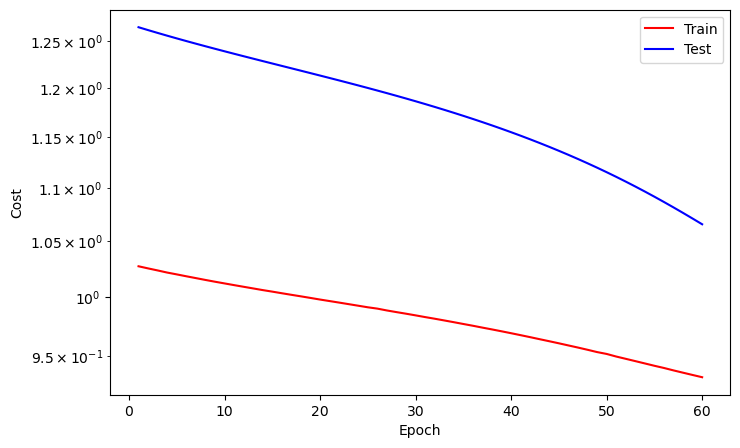

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 0.9310 | Test_cost  = 1.0602 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 0.9290 | Test_cost  = 1.0548 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 0.9277 | Test_cost  = 1.0494 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 0.9261 | Test_cost  = 1.0440 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 0.9247 | Test_cost  = 1.0387 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 0.9234 | Test_cost  = 1.0335 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 0.9224 | Test_cost  = 1.0284 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 0.9211 | Test_cost  = 1.0235 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 0.9201 | Test_cost  = 1.0188 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 0.9198 | Test_cost  = 1.0143 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 0.9183 | Test_cost  = 1.0101 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 0.9175 | Test_cost  = 1.0062 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 0.9166 | Test_cost  = 1.0027 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 0.9159 | Test_cost  = 0.9994 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 0.9151 | Test_cost  = 0.9965 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 0.9141 | Test_cost  = 0.9940 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 0.9132 | Test_cost  = 0.9917 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 0.9121 | Test_cost  = 0.9898 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 0.9108 | Test_cost  = 0.9882 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 0.9096 | Test_cost  = 0.9868 | 


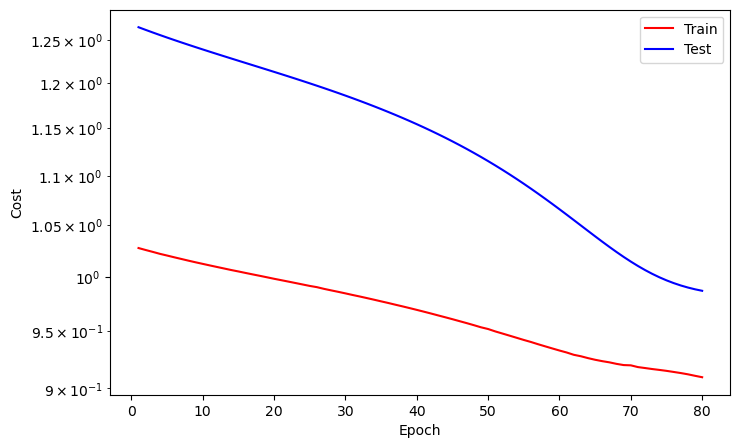

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 0.9084 | Test_cost  = 0.9856 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 0.9069 | Test_cost  = 0.9846 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 0.9055 | Test_cost  = 0.9838 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 0.9042 | Test_cost  = 0.9831 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 0.9023 | Test_cost  = 0.9824 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 0.9006 | Test_cost  = 0.9818 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 0.8991 | Test_cost  = 0.9811 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 0.8972 | Test_cost  = 0.9804 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 0.8963 | Test_cost  = 0.9795 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 0.8941 | Test_cost  = 0.9784 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 0.8923 | Test_cost  = 0.9772 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 0.8907 | Test_cost  = 0.9757 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 0.8886 | Test_cost  = 0.9739 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 0.8868 | Test_cost  = 0.9718 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 0.8849 | Test_cost  = 0.9693 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 0.8828 | Test_cost  = 0.9666 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 0.8807 | Test_cost  = 0.9635 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 0.8785 | Test_cost  = 0.9601 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 0.8761 | Test_cost  = 0.9563 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 0.8733 | Test_cost  = 0.9522 | 


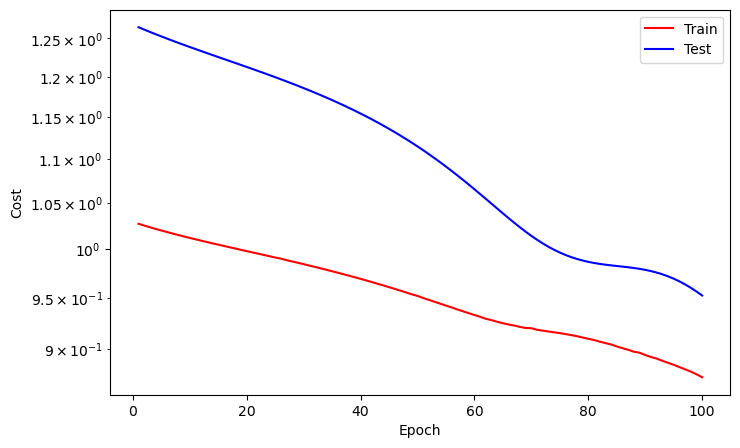

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 0.8712 | Test_cost  = 0.9478 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 0.8685 | Test_cost  = 0.9432 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 0.8665 | Test_cost  = 0.9384 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 0.8629 | Test_cost  = 0.9334 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 0.8598 | Test_cost  = 0.9282 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 0.8570 | Test_cost  = 0.9229 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 0.8539 | Test_cost  = 0.9176 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 0.8507 | Test_cost  = 0.9122 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 0.8471 | Test_cost  = 0.9068 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 0.8439 | Test_cost  = 0.9015 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 0.8403 | Test_cost  = 0.8961 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 0.8359 | Test_cost  = 0.8908 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 0.8334 | Test_cost  = 0.8856 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 0.8287 | Test_cost  = 0.8804 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 0.8262 | Test_cost  = 0.8753 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 0.8207 | Test_cost  = 0.8701 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 0.8164 | Test_cost  = 0.8649 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 0.8118 | Test_cost  = 0.8596 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 0.8072 | Test_cost  = 0.8541 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 0.8025 | Test_cost  = 0.8484 | 


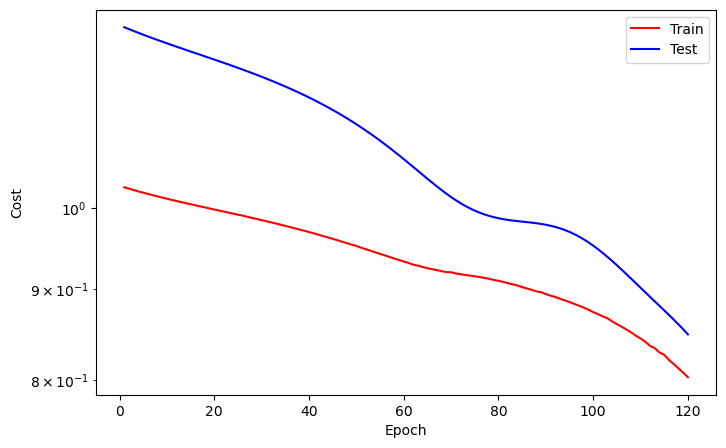

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 0.7978 | Test_cost  = 0.8426 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 0.7924 | Test_cost  = 0.8365 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 0.7868 | Test_cost  = 0.8302 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 0.7817 | Test_cost  = 0.8237 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 0.7764 | Test_cost  = 0.8170 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 0.7711 | Test_cost  = 0.8100 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 0.7646 | Test_cost  = 0.8029 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 0.7586 | Test_cost  = 0.7957 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 0.7536 | Test_cost  = 0.7882 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 0.7460 | Test_cost  = 0.7806 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 0.7392 | Test_cost  = 0.7729 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 0.7330 | Test_cost  = 0.7652 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 0.7256 | Test_cost  = 0.7573 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 0.7198 | Test_cost  = 0.7494 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 0.7110 | Test_cost  = 0.7415 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 0.7018 | Test_cost  = 0.7335 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 0.6959 | Test_cost  = 0.7254 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 0.6883 | Test_cost  = 0.7174 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 0.6802 | Test_cost  = 0.7093 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 0.6716 | Test_cost  = 0.7011 | 


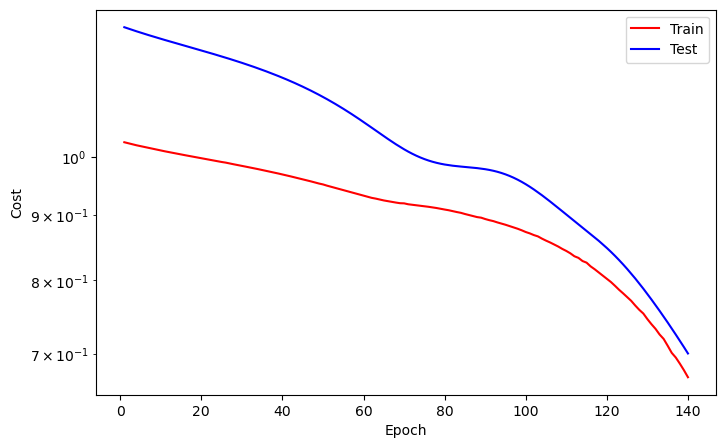

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 0.6656 | Test_cost  = 0.6929 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 0.6562 | Test_cost  = 0.6846 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 0.6477 | Test_cost  = 0.6764 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 0.6397 | Test_cost  = 0.6681 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 0.6316 | Test_cost  = 0.6599 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 0.6230 | Test_cost  = 0.6516 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 0.6145 | Test_cost  = 0.6433 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 0.6070 | Test_cost  = 0.6350 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 0.5980 | Test_cost  = 0.6266 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 0.5902 | Test_cost  = 0.6183 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 0.5824 | Test_cost  = 0.6099 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 0.5724 | Test_cost  = 0.6015 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 0.5649 | Test_cost  = 0.5932 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 0.5563 | Test_cost  = 0.5849 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 0.5489 | Test_cost  = 0.5766 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 0.5398 | Test_cost  = 0.5684 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 0.5324 | Test_cost  = 0.5602 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 0.5247 | Test_cost  = 0.5520 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 0.5172 | Test_cost  = 0.5439 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 0.5092 | Test_cost  = 0.5357 | 


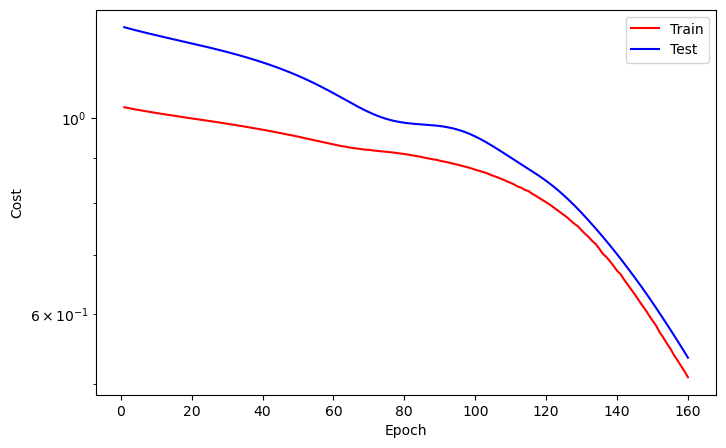

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 0.5006 | Test_cost  = 0.5275 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 0.4928 | Test_cost  = 0.5194 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 0.4853 | Test_cost  = 0.5112 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 0.4785 | Test_cost  = 0.5030 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 0.4703 | Test_cost  = 0.4948 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 0.4623 | Test_cost  = 0.4867 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 0.4551 | Test_cost  = 0.4787 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 0.4479 | Test_cost  = 0.4707 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 0.4401 | Test_cost  = 0.4627 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 0.4340 | Test_cost  = 0.4548 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 0.4259 | Test_cost  = 0.4470 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 0.4183 | Test_cost  = 0.4394 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 0.4118 | Test_cost  = 0.4319 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 0.4049 | Test_cost  = 0.4245 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 0.3978 | Test_cost  = 0.4173 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 0.3905 | Test_cost  = 0.4102 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 0.3844 | Test_cost  = 0.4032 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 0.3782 | Test_cost  = 0.3964 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 0.3717 | Test_cost  = 0.3898 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 0.3661 | Test_cost  = 0.3833 | 


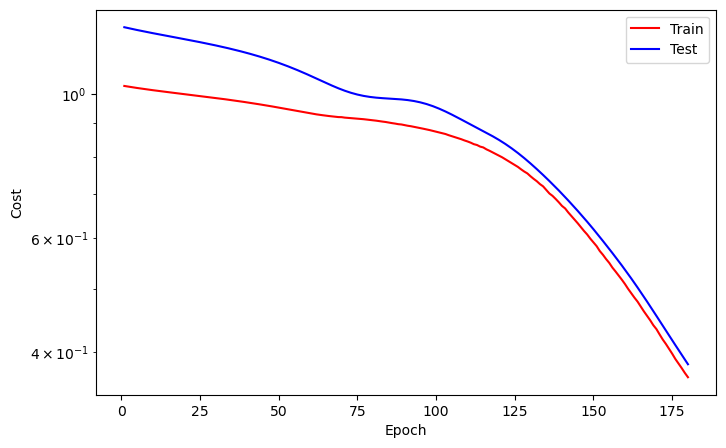

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 0.3594 | Test_cost  = 0.3770 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 0.3532 | Test_cost  = 0.3708 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 0.3472 | Test_cost  = 0.3646 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 0.3416 | Test_cost  = 0.3586 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 0.3357 | Test_cost  = 0.3527 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 0.3292 | Test_cost  = 0.3469 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 0.3247 | Test_cost  = 0.3411 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 0.3192 | Test_cost  = 0.3355 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 0.3145 | Test_cost  = 0.3300 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 0.3101 | Test_cost  = 0.3244 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 0.3038 | Test_cost  = 0.3190 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 0.2990 | Test_cost  = 0.3138 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 0.2941 | Test_cost  = 0.3087 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 0.2880 | Test_cost  = 0.3036 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 0.2866 | Test_cost  = 0.2987 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 0.2799 | Test_cost  = 0.2939 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 0.2771 | Test_cost  = 0.2892 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   198
Train_cost  = 0.2720 | Test_cost  = 0.2847 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   199
Train_cost  = 0.2679 | Test_cost  = 0.2804 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   200
Train_cost  = 0.2638 | Test_cost  = 0.2763 | 


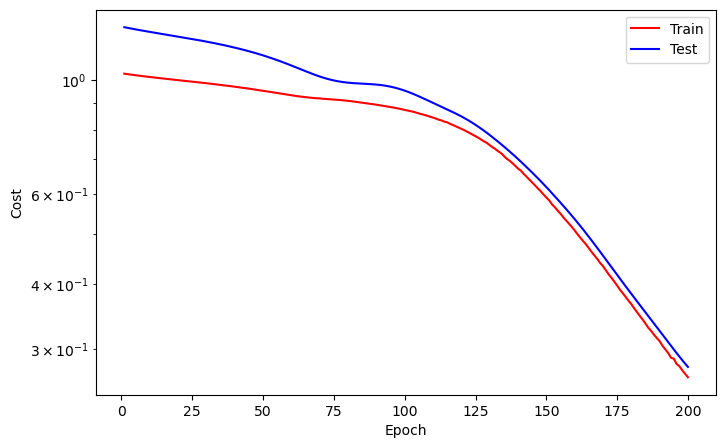

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 0.2600 | Test_cost  = 0.2722 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 0.2561 | Test_cost  = 0.2683 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 0.2526 | Test_cost  = 0.2645 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 0.2488 | Test_cost  = 0.2608 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 0.2456 | Test_cost  = 0.2571 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 0.2418 | Test_cost  = 0.2536 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   207
Train_cost  = 0.2370 | Test_cost  = 0.2500 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   208
Train_cost  = 0.2344 | Test_cost  = 0.2464 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   209
Train_cost  = 0.2321 | Test_cost  = 0.2429 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   210
Train_cost  = 0.2306 | Test_cost  = 0.2395 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   211
Train_cost  = 0.2261 | Test_cost  = 0.2362 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   212
Train_cost  = 0.2227 | Test_cost  = 0.2330 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   213
Train_cost  = 0.2210 | Test_cost  = 0.2299 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   214
Train_cost  = 0.2186 | Test_cost  = 0.2267 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   215
Train_cost  = 0.2146 | Test_cost  = 0.2237 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   216
Train_cost  = 0.2119 | Test_cost  = 0.2208 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   217
Train_cost  = 0.2093 | Test_cost  = 0.2180 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   218
Train_cost  = 0.2060 | Test_cost  = 0.2153 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   219
Train_cost  = 0.2043 | Test_cost  = 0.2127 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   220
Train_cost  = 0.2018 | Test_cost  = 0.2101 | 


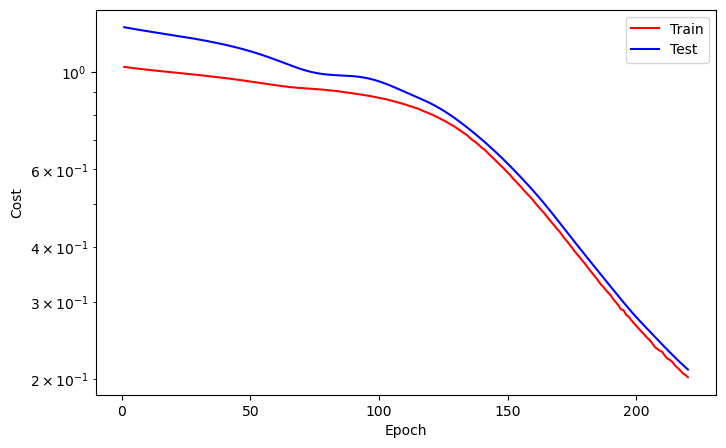

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   221
Train_cost  = 0.2019 | Test_cost  = 0.2077 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   222
Train_cost  = 0.1972 | Test_cost  = 0.2052 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   223
Train_cost  = 0.1958 | Test_cost  = 0.2028 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   224
Train_cost  = 0.1921 | Test_cost  = 0.2003 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   225
Train_cost  = 0.1904 | Test_cost  = 0.1978 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   226
Train_cost  = 0.1883 | Test_cost  = 0.1952 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   227
Train_cost  = 0.1856 | Test_cost  = 0.1928 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   228
Train_cost  = 0.1842 | Test_cost  = 0.1903 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   229
Train_cost  = 0.1817 | Test_cost  = 0.1880 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   230
Train_cost  = 0.1819 | Test_cost  = 0.1857 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   231
Train_cost  = 0.1784 | Test_cost  = 0.1836 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   232
Train_cost  = 0.1766 | Test_cost  = 0.1814 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   233
Train_cost  = 0.1748 | Test_cost  = 0.1793 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   234
Train_cost  = 0.1731 | Test_cost  = 0.1773 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   235
Train_cost  = 0.1717 | Test_cost  = 0.1752 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   236
Train_cost  = 0.1699 | Test_cost  = 0.1733 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   237
Train_cost  = 0.1680 | Test_cost  = 0.1715 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   238
Train_cost  = 0.1666 | Test_cost  = 0.1698 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   239
Train_cost  = 0.1651 | Test_cost  = 0.1681 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   240
Train_cost  = 0.1639 | Test_cost  = 0.1668 | 


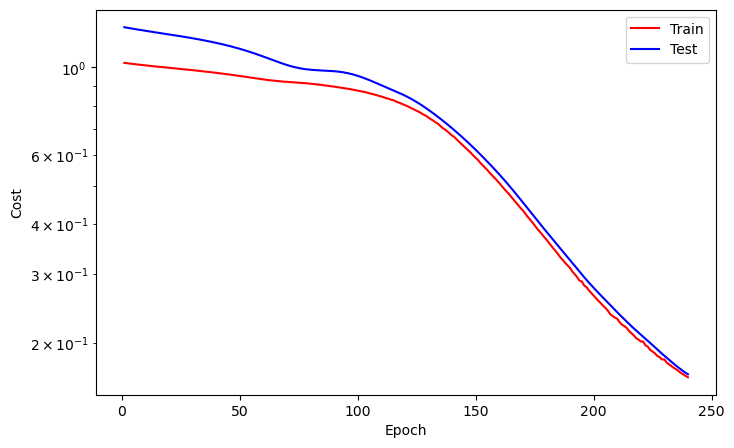

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   241
Train_cost  = 0.1615 | Test_cost  = 0.1653 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   242
Train_cost  = 0.1606 | Test_cost  = 0.1637 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   243
Train_cost  = 0.1604 | Test_cost  = 0.1620 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   244
Train_cost  = 0.1584 | Test_cost  = 0.1602 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   245
Train_cost  = 0.1569 | Test_cost  = 0.1586 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   246
Train_cost  = 0.1563 | Test_cost  = 0.1573 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   247
Train_cost  = 0.1544 | Test_cost  = 0.1561 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   248
Train_cost  = 0.1537 | Test_cost  = 0.1547 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   249
Train_cost  = 0.1514 | Test_cost  = 0.1533 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   250
Train_cost  = 0.1509 | Test_cost  = 0.1519 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   251
Train_cost  = 0.1498 | Test_cost  = 0.1505 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   252
Train_cost  = 0.1487 | Test_cost  = 0.1492 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   253
Train_cost  = 0.1475 | Test_cost  = 0.1480 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   254
Train_cost  = 0.1464 | Test_cost  = 0.1469 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   255
Train_cost  = 0.1454 | Test_cost  = 0.1455 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   256
Train_cost  = 0.1453 | Test_cost  = 0.1442 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   257
Train_cost  = 0.1431 | Test_cost  = 0.1431 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   258
Train_cost  = 0.1424 | Test_cost  = 0.1424 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   259
Train_cost  = 0.1409 | Test_cost  = 0.1419 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   260
Train_cost  = 0.1405 | Test_cost  = 0.1411 | 


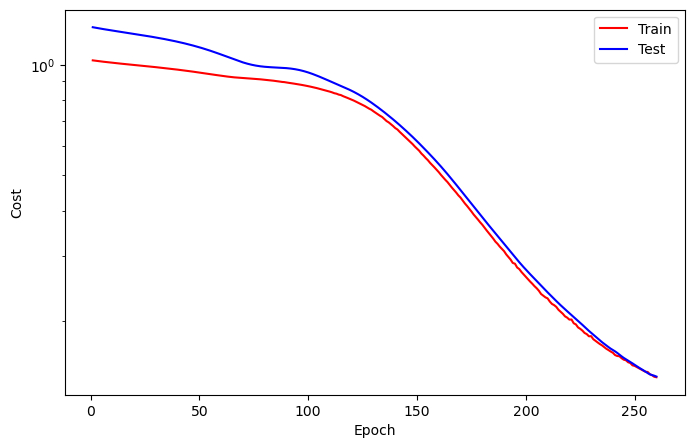

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   261
Train_cost  = 0.1388 | Test_cost  = 0.1403 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   262
Train_cost  = 0.1377 | Test_cost  = 0.1395 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   263
Train_cost  = 0.1394 | Test_cost  = 0.1385 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   264
Train_cost  = 0.1356 | Test_cost  = 0.1378 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   265
Train_cost  = 0.1336 | Test_cost  = 0.1373 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   266
Train_cost  = 0.1330 | Test_cost  = 0.1368 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   267
Train_cost  = 0.1335 | Test_cost  = 0.1364 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   268
Train_cost  = 0.1313 | Test_cost  = 0.1357 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   269
Train_cost  = 0.1329 | Test_cost  = 0.1345 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   270
Train_cost  = 0.1294 | Test_cost  = 0.1334 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   271
Train_cost  = 0.1286 | Test_cost  = 0.1322 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   272
Train_cost  = 0.1274 | Test_cost  = 0.1314 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   273
Train_cost  = 0.1266 | Test_cost  = 0.1303 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   274
Train_cost  = 0.1252 | Test_cost  = 0.1296 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   275
Train_cost  = 0.1262 | Test_cost  = 0.1292 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   276
Train_cost  = 0.1234 | Test_cost  = 0.1286 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   277
Train_cost  = 0.1223 | Test_cost  = 0.1276 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   278
Train_cost  = 0.1213 | Test_cost  = 0.1263 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   279
Train_cost  = 0.1204 | Test_cost  = 0.1250 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   280
Train_cost  = 0.1185 | Test_cost  = 0.1239 | 


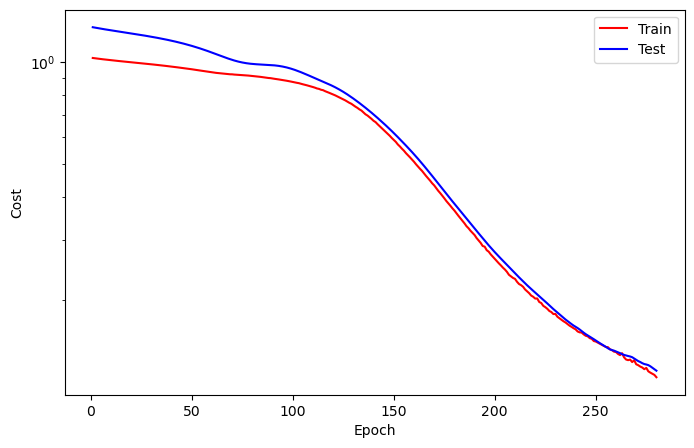

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   281
Train_cost  = 0.1191 | Test_cost  = 0.1232 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   282
Train_cost  = 0.1180 | Test_cost  = 0.1229 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   283
Train_cost  = 0.1172 | Test_cost  = 0.1221 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   284
Train_cost  = 0.1162 | Test_cost  = 0.1214 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   285
Train_cost  = 0.1155 | Test_cost  = 0.1208 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   286
Train_cost  = 0.1164 | Test_cost  = 0.1204 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   287
Train_cost  = 0.1141 | Test_cost  = 0.1199 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   288
Train_cost  = 0.1146 | Test_cost  = 0.1190 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   289
Train_cost  = 0.1128 | Test_cost  = 0.1183 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   290
Train_cost  = 0.1124 | Test_cost  = 0.1178 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   291
Train_cost  = 0.1126 | Test_cost  = 0.1172 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   292
Train_cost  = 0.1107 | Test_cost  = 0.1169 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   293
Train_cost  = 0.1103 | Test_cost  = 0.1169 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   294
Train_cost  = 0.1092 | Test_cost  = 0.1171 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1169


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   295
Train_cost  = 0.1116 | Test_cost  = 0.1161 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   296
Train_cost  = 0.1089 | Test_cost  = 0.1148 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   297
Train_cost  = 0.1084 | Test_cost  = 0.1137 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   298
Train_cost  = 0.1080 | Test_cost  = 0.1132 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   299
Train_cost  = 0.1079 | Test_cost  = 0.1130 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   300
Train_cost  = 0.1082 | Test_cost  = 0.1126 | 


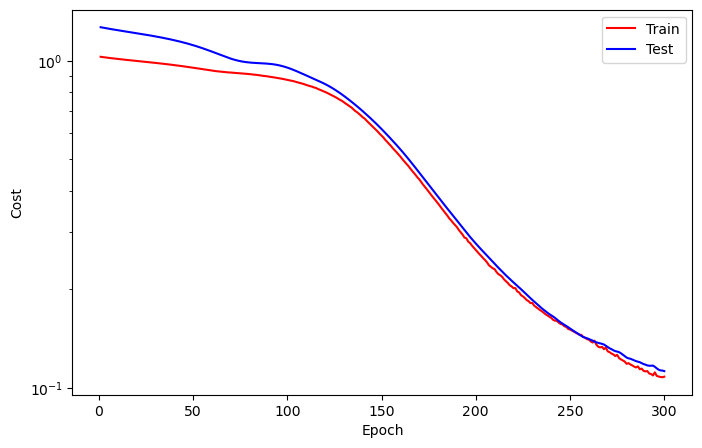

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   301
Train_cost  = 0.1066 | Test_cost  = 0.1123 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   302
Train_cost  = 0.1058 | Test_cost  = 0.1113 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   303
Train_cost  = 0.1051 | Test_cost  = 0.1113 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1113


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   304
Train_cost  = 0.1050 | Test_cost  = 0.1117 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1113


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   305
Train_cost  = 0.1069 | Test_cost  = 0.1112 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   306
Train_cost  = 0.1049 | Test_cost  = 0.1098 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   307
Train_cost  = 0.1051 | Test_cost  = 0.1085 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   308
Train_cost  = 0.1043 | Test_cost  = 0.1078 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   309
Train_cost  = 0.1034 | Test_cost  = 0.1079 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1078


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   310
Train_cost  = 0.1035 | Test_cost  = 0.1088 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1078


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   311
Train_cost  = 0.1031 | Test_cost  = 0.1097 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1078


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   312
Train_cost  = 0.1037 | Test_cost  = 0.1089 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1078


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   313
Train_cost  = 0.1026 | Test_cost  = 0.1073 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   314
Train_cost  = 0.1026 | Test_cost  = 0.1061 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   315
Train_cost  = 0.1011 | Test_cost  = 0.1054 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   316
Train_cost  = 0.1022 | Test_cost  = 0.1054 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1054


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   317
Train_cost  = 0.1021 | Test_cost  = 0.1062 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1054


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   318
Train_cost  = 0.1018 | Test_cost  = 0.1069 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1054


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   319
Train_cost  = 0.1018 | Test_cost  = 0.1069 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1054


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   320
Train_cost  = 0.1004 | Test_cost  = 0.1052 | 


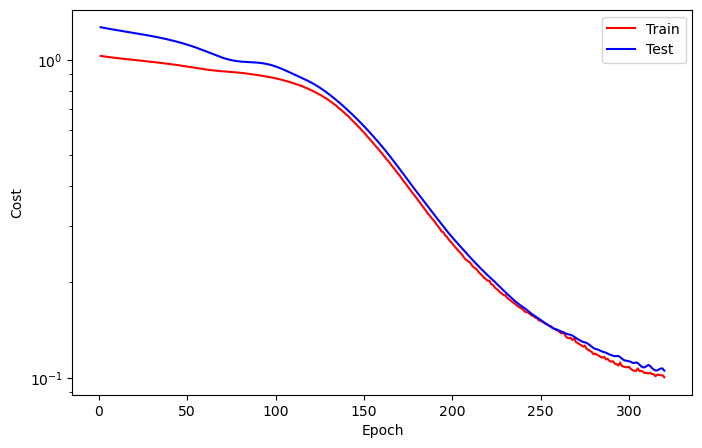

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   321
Train_cost  = 0.1013 | Test_cost  = 0.1039 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   322
Train_cost  = 0.1006 | Test_cost  = 0.1036 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   323
Train_cost  = 0.0999 | Test_cost  = 0.1043 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1036


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   324
Train_cost  = 0.1001 | Test_cost  = 0.1050 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1036


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   325
Train_cost  = 0.0999 | Test_cost  = 0.1046 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1036


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   326
Train_cost  = 0.0997 | Test_cost  = 0.1033 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   327
Train_cost  = 0.1015 | Test_cost  = 0.1021 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   328
Train_cost  = 0.0985 | Test_cost  = 0.1017 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   329
Train_cost  = 0.0991 | Test_cost  = 0.1021 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1017


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   330
Train_cost  = 0.0996 | Test_cost  = 0.1030 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1017


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   331
Train_cost  = 0.0987 | Test_cost  = 0.1033 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1017


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   332
Train_cost  = 0.0986 | Test_cost  = 0.1025 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1017


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   333
Train_cost  = 0.0987 | Test_cost  = 0.1014 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   334
Train_cost  = 0.0987 | Test_cost  = 0.1004 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   335
Train_cost  = 0.0980 | Test_cost  = 0.1001 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   336
Train_cost  = 0.0980 | Test_cost  = 0.1009 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1001


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   337
Train_cost  = 0.0974 | Test_cost  = 0.1020 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1001


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   338
Train_cost  = 0.0976 | Test_cost  = 0.1019 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1001


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   339
Train_cost  = 0.0983 | Test_cost  = 0.0996 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   340
Train_cost  = 0.0972 | Test_cost  = 0.0981 | 


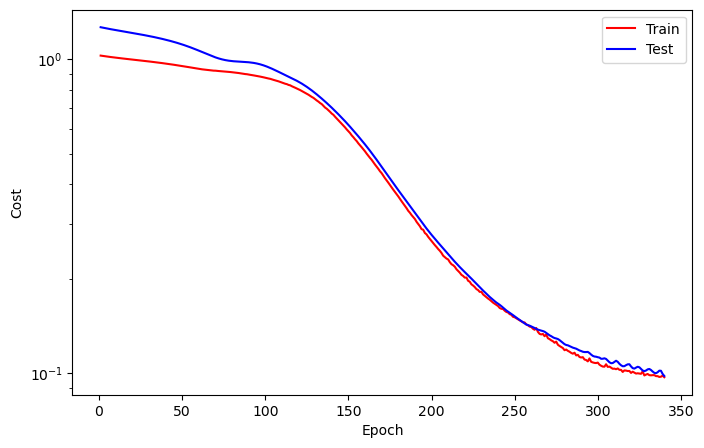

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   341
Train_cost  = 0.0972 | Test_cost  = 0.0982 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0981


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   342
Train_cost  = 0.0988 | Test_cost  = 0.0994 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0981


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   343
Train_cost  = 0.0971 | Test_cost  = 0.1008 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0981


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   344
Train_cost  = 0.0955 | Test_cost  = 0.1008 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0981


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   345
Train_cost  = 0.0952 | Test_cost  = 0.0987 | 
==> EarlyStop patience =  5 | Best test_cost: 0.0981
==> Execute Early Stopping at epoch: 345 | Best test_cost: 0.0981
==> Best model is saved at model/lstm1


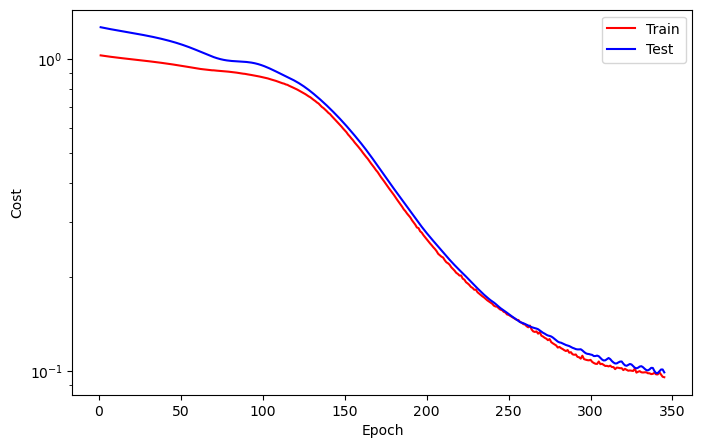

In [25]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Forecast

In [38]:
def data4pred(model, dataset, dataloader, device):    
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)
            
            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()

def pred4pred(model, dataset, dataloader, device, n_prior=39, n_forecast=30):
    preds, targets = [], []
    hidden = None    
    end = n_prior + n_forecast    
    with torch.no_grad():
        model.eval()       
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]
                
            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)
            
            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()   
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()

In [39]:
train_forecast_set = TimeSeriesDataset(ts_train, "united_states_all_sectors", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "united_states_all_sectors", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (203, 1, 1)
Note: last 0 data excluded

(N, S, F): (50, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

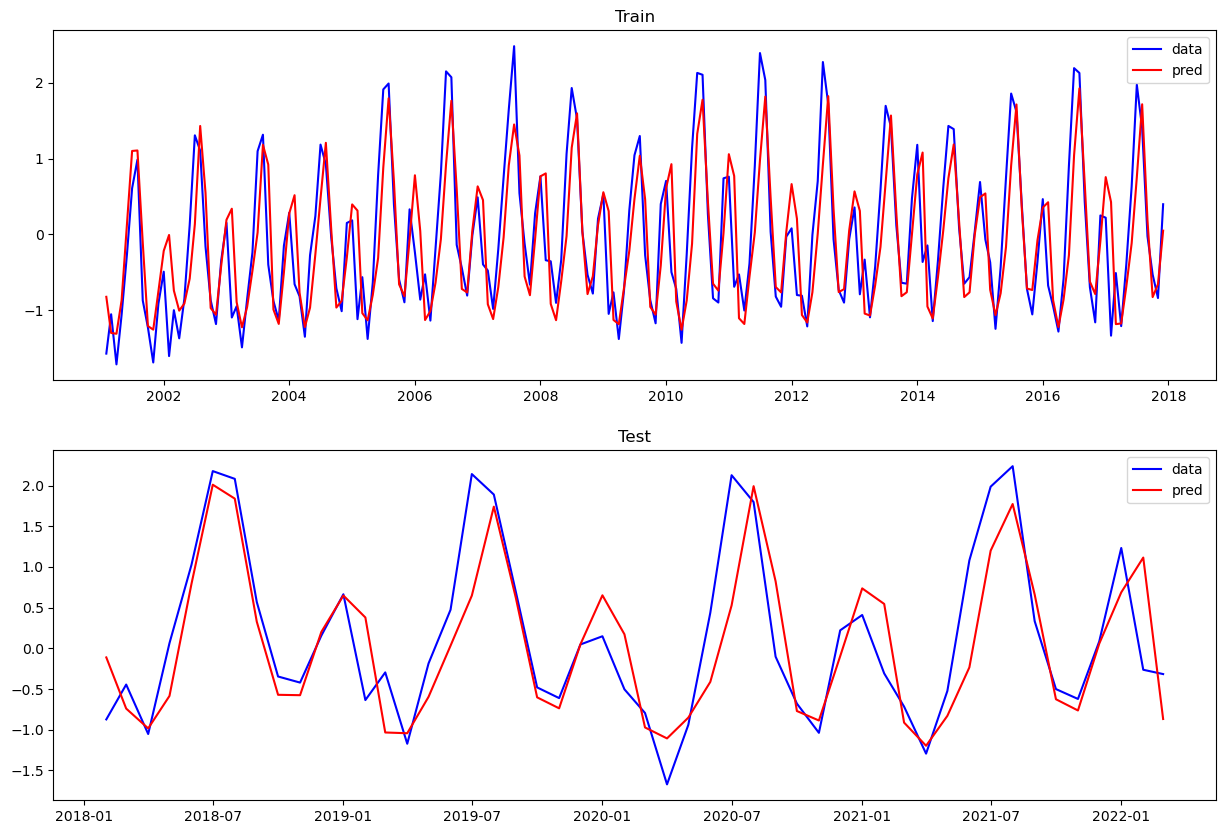

In [40]:
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'Test')

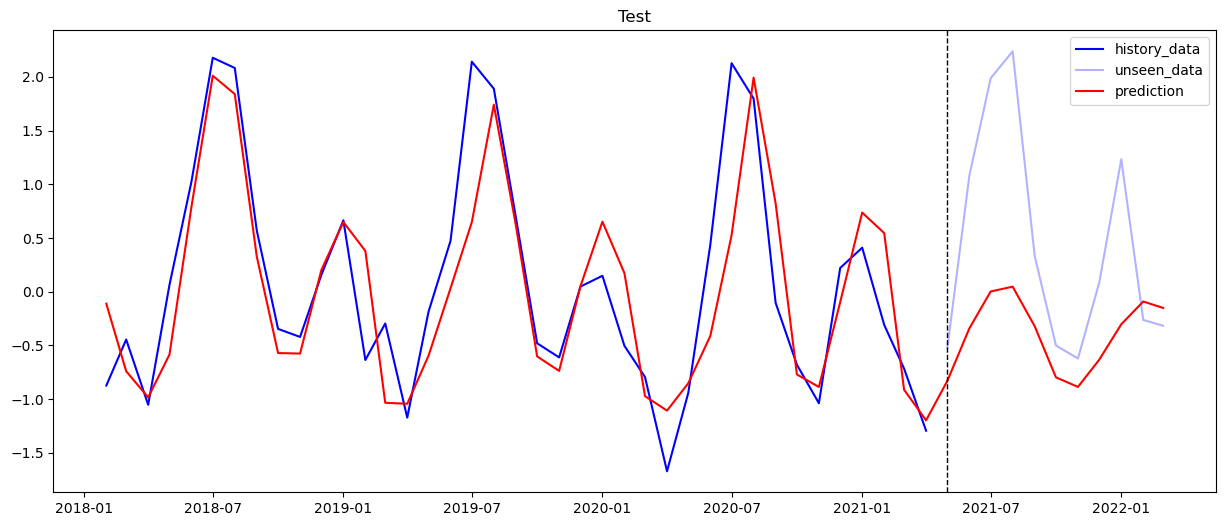

In [41]:
plt.figure(figsize=(15, 6))

pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

# With GRU 

## Arch and Config

In [42]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [43]:
config = set_config({
    'input_size': train_set.n_feature,
    'output_size': 1,
    'hidden_size': 8,
    'num_layers': 2,
    'dropout': 0.001,
    'seq_len': train_set.n_seq
})

##  Training Preparation

In [44]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/gru")

## Training

In [45]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.9933 | Test_cost  = 1.1676 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.9904 | Test_cost  = 1.1615 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.9878 | Test_cost  = 1.1556 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.9852 | Test_cost  = 1.1498 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.9827 | Test_cost  = 1.1441 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.9802 | Test_cost  = 1.1387 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.9782 | Test_cost  = 1.1334 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.9762 | Test_cost  = 1.1283 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.9743 | Test_cost  = 1.1234 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.9725 | Test_cost  = 1.1187 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.9711 | Test_cost  = 1.1142 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.9695 | Test_cost  = 1.1099 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.9678 | Test_cost  = 1.1058 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.9669 | Test_cost  = 1.1019 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.9652 | Test_cost  = 1.0982 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.9640 | Test_cost  = 1.0947 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.9626 | Test_cost  = 1.0913 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.9615 | Test_cost  = 1.0880 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.9603 | Test_cost  = 1.0849 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.9597 | Test_cost  = 1.0820 | 


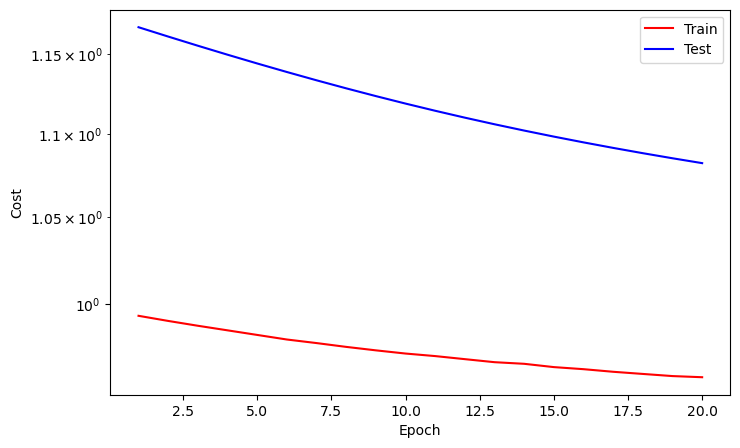

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.9581 | Test_cost  = 1.0792 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.9572 | Test_cost  = 1.0764 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.9559 | Test_cost  = 1.0738 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.9556 | Test_cost  = 1.0713 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.9536 | Test_cost  = 1.0688 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.9525 | Test_cost  = 1.0665 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.9515 | Test_cost  = 1.0642 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.9502 | Test_cost  = 1.0619 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.9493 | Test_cost  = 1.0598 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.9478 | Test_cost  = 1.0577 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.9465 | Test_cost  = 1.0556 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.9455 | Test_cost  = 1.0536 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.9440 | Test_cost  = 1.0516 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.9425 | Test_cost  = 1.0496 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.9412 | Test_cost  = 1.0476 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.9407 | Test_cost  = 1.0457 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.9383 | Test_cost  = 1.0438 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.9370 | Test_cost  = 1.0418 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.9358 | Test_cost  = 1.0399 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.9337 | Test_cost  = 1.0379 | 


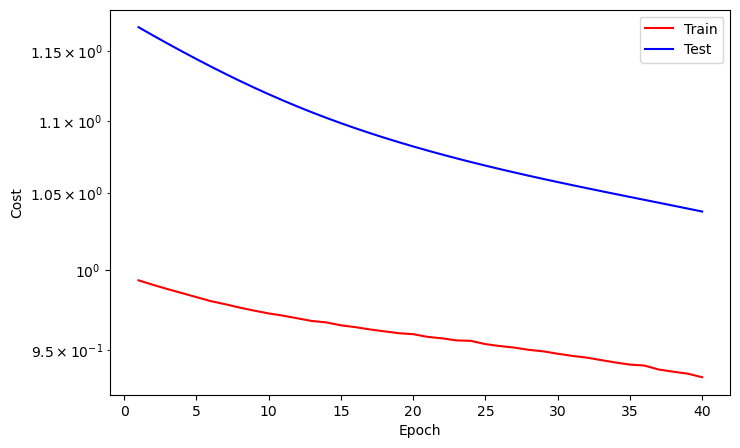

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.9323 | Test_cost  = 1.0359 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.9307 | Test_cost  = 1.0339 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.9297 | Test_cost  = 1.0319 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 0.9273 | Test_cost  = 1.0298 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 0.9257 | Test_cost  = 1.0277 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 0.9239 | Test_cost  = 1.0255 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 0.9219 | Test_cost  = 1.0232 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 0.9200 | Test_cost  = 1.0209 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 0.9181 | Test_cost  = 1.0185 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 0.9160 | Test_cost  = 1.0160 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 0.9146 | Test_cost  = 1.0134 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 0.9119 | Test_cost  = 1.0108 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 0.9098 | Test_cost  = 1.0080 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 0.9074 | Test_cost  = 1.0052 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 0.9050 | Test_cost  = 1.0022 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 0.9026 | Test_cost  = 0.9991 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 0.9000 | Test_cost  = 0.9959 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 0.8978 | Test_cost  = 0.9926 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 0.8952 | Test_cost  = 0.9892 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 0.8922 | Test_cost  = 0.9857 | 


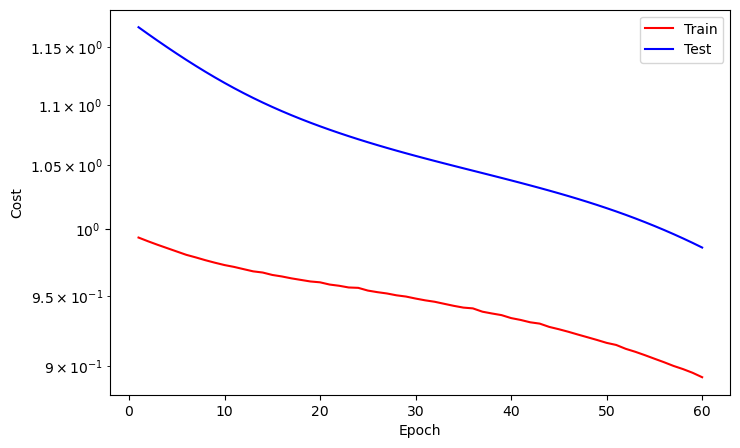

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 0.8894 | Test_cost  = 0.9820 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 0.8864 | Test_cost  = 0.9783 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 0.8841 | Test_cost  = 0.9744 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 0.8811 | Test_cost  = 0.9704 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 0.8784 | Test_cost  = 0.9662 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 0.8747 | Test_cost  = 0.9620 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 0.8713 | Test_cost  = 0.9576 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 0.8688 | Test_cost  = 0.9532 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 0.8640 | Test_cost  = 0.9486 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 0.8604 | Test_cost  = 0.9438 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 0.8570 | Test_cost  = 0.9390 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 0.8551 | Test_cost  = 0.9340 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 0.8502 | Test_cost  = 0.9289 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 0.8454 | Test_cost  = 0.9237 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 0.8415 | Test_cost  = 0.9184 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 0.8365 | Test_cost  = 0.9129 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 0.8327 | Test_cost  = 0.9073 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 0.8280 | Test_cost  = 0.9016 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 0.8235 | Test_cost  = 0.8957 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 0.8196 | Test_cost  = 0.8897 | 


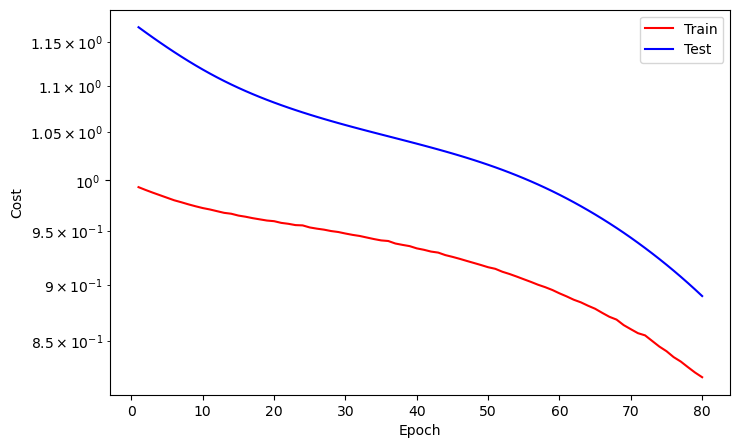

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 0.8138 | Test_cost  = 0.8836 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 0.8087 | Test_cost  = 0.8774 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 0.8036 | Test_cost  = 0.8710 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 0.7981 | Test_cost  = 0.8644 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 0.7932 | Test_cost  = 0.8577 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 0.7869 | Test_cost  = 0.8509 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 0.7808 | Test_cost  = 0.8438 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 0.7750 | Test_cost  = 0.8366 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 0.7692 | Test_cost  = 0.8293 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 0.7626 | Test_cost  = 0.8217 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 0.7564 | Test_cost  = 0.8140 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 0.7495 | Test_cost  = 0.8062 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 0.7427 | Test_cost  = 0.7981 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 0.7354 | Test_cost  = 0.7899 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 0.7286 | Test_cost  = 0.7816 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 0.7212 | Test_cost  = 0.7730 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 0.7150 | Test_cost  = 0.7644 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 0.7075 | Test_cost  = 0.7555 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 0.6987 | Test_cost  = 0.7466 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 0.6924 | Test_cost  = 0.7375 | 


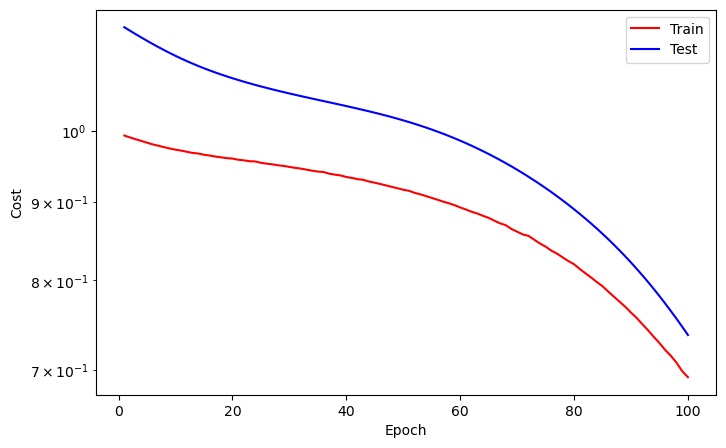

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 0.6826 | Test_cost  = 0.7283 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 0.6749 | Test_cost  = 0.7190 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 0.6671 | Test_cost  = 0.7096 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 0.6584 | Test_cost  = 0.7002 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 0.6498 | Test_cost  = 0.6907 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 0.6415 | Test_cost  = 0.6811 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 0.6308 | Test_cost  = 0.6715 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 0.6243 | Test_cost  = 0.6618 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 0.6154 | Test_cost  = 0.6521 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 0.6068 | Test_cost  = 0.6424 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 0.5994 | Test_cost  = 0.6328 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 0.5900 | Test_cost  = 0.6232 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 0.5809 | Test_cost  = 0.6136 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 0.5706 | Test_cost  = 0.6041 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 0.5615 | Test_cost  = 0.5946 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 0.5527 | Test_cost  = 0.5851 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 0.5445 | Test_cost  = 0.5758 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 0.5358 | Test_cost  = 0.5667 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 0.5265 | Test_cost  = 0.5576 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 0.5182 | Test_cost  = 0.5487 | 


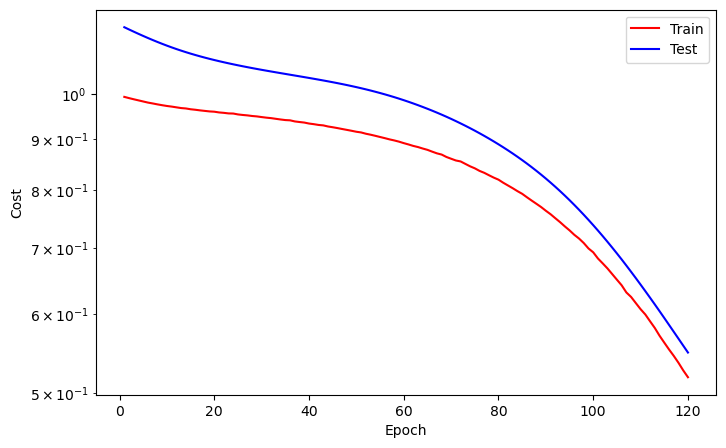

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 0.5097 | Test_cost  = 0.5400 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 0.5012 | Test_cost  = 0.5313 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 0.4923 | Test_cost  = 0.5228 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 0.4843 | Test_cost  = 0.5144 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 0.4775 | Test_cost  = 0.5061 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 0.4684 | Test_cost  = 0.4979 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 0.4602 | Test_cost  = 0.4899 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 0.4533 | Test_cost  = 0.4819 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 0.4446 | Test_cost  = 0.4741 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 0.4351 | Test_cost  = 0.4663 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 0.4307 | Test_cost  = 0.4587 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 0.4213 | Test_cost  = 0.4511 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 0.4151 | Test_cost  = 0.4437 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 0.4080 | Test_cost  = 0.4365 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 0.4012 | Test_cost  = 0.4295 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 0.3955 | Test_cost  = 0.4227 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 0.3877 | Test_cost  = 0.4160 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 0.3812 | Test_cost  = 0.4095 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 0.3756 | Test_cost  = 0.4032 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 0.3682 | Test_cost  = 0.3970 | 


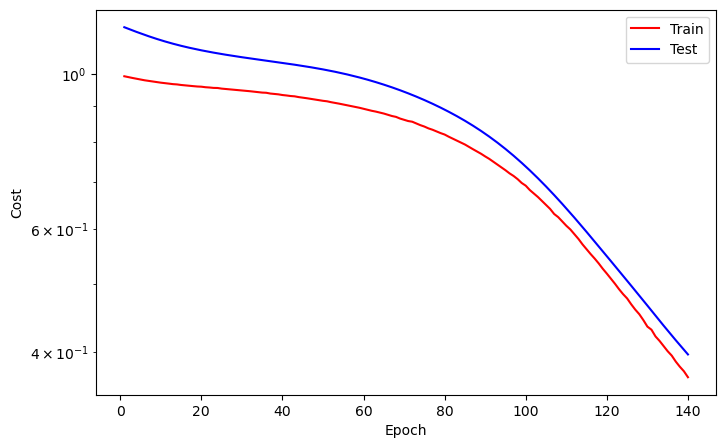

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 0.3613 | Test_cost  = 0.3908 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 0.3567 | Test_cost  = 0.3848 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 0.3526 | Test_cost  = 0.3789 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 0.3466 | Test_cost  = 0.3731 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 0.3398 | Test_cost  = 0.3673 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 0.3338 | Test_cost  = 0.3616 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 0.3298 | Test_cost  = 0.3560 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 0.3238 | Test_cost  = 0.3504 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 0.3186 | Test_cost  = 0.3449 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 0.3136 | Test_cost  = 0.3396 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 0.3053 | Test_cost  = 0.3343 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 0.3047 | Test_cost  = 0.3291 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 0.3003 | Test_cost  = 0.3240 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 0.2939 | Test_cost  = 0.3190 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 0.2893 | Test_cost  = 0.3142 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 0.2872 | Test_cost  = 0.3095 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 0.2824 | Test_cost  = 0.3050 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 0.2788 | Test_cost  = 0.3006 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 0.2786 | Test_cost  = 0.2964 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 0.2708 | Test_cost  = 0.2923 | 


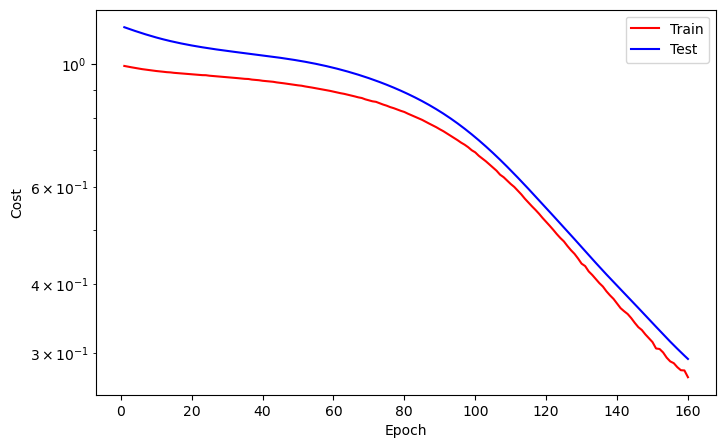

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 0.2683 | Test_cost  = 0.2883 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 0.2644 | Test_cost  = 0.2844 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 0.2591 | Test_cost  = 0.2806 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 0.2573 | Test_cost  = 0.2770 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 0.2538 | Test_cost  = 0.2735 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 0.2504 | Test_cost  = 0.2700 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 0.2477 | Test_cost  = 0.2668 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 0.2453 | Test_cost  = 0.2635 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 0.2421 | Test_cost  = 0.2604 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 0.2429 | Test_cost  = 0.2573 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 0.2353 | Test_cost  = 0.2543 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 0.2344 | Test_cost  = 0.2515 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 0.2322 | Test_cost  = 0.2488 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 0.2301 | Test_cost  = 0.2462 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 0.2274 | Test_cost  = 0.2437 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 0.2256 | Test_cost  = 0.2414 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 0.2245 | Test_cost  = 0.2392 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 0.2217 | Test_cost  = 0.2371 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 0.2214 | Test_cost  = 0.2350 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 0.2203 | Test_cost  = 0.2330 | 


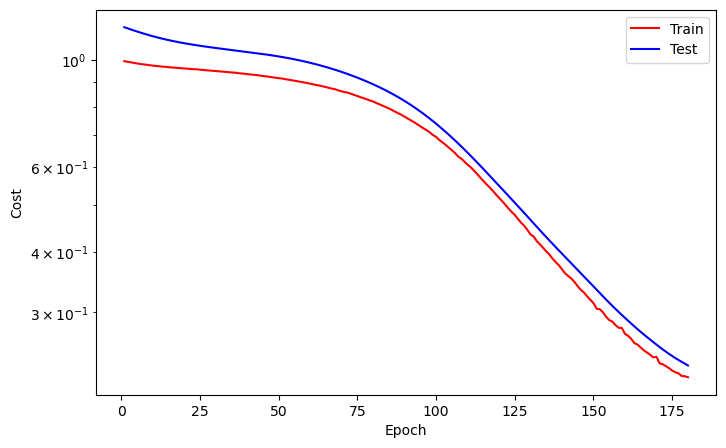

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 0.2165 | Test_cost  = 0.2312 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 0.2138 | Test_cost  = 0.2293 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 0.2134 | Test_cost  = 0.2276 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 0.2121 | Test_cost  = 0.2260 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 0.2105 | Test_cost  = 0.2245 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 0.2107 | Test_cost  = 0.2230 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 0.2083 | Test_cost  = 0.2217 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 0.2063 | Test_cost  = 0.2203 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 0.2069 | Test_cost  = 0.2189 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 0.2044 | Test_cost  = 0.2177 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 0.2045 | Test_cost  = 0.2163 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 0.2023 | Test_cost  = 0.2152 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 0.2003 | Test_cost  = 0.2141 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 0.2009 | Test_cost  = 0.2133 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 0.1994 | Test_cost  = 0.2125 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 0.1992 | Test_cost  = 0.2118 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 0.1973 | Test_cost  = 0.2110 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   198
Train_cost  = 0.1981 | Test_cost  = 0.2103 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   199
Train_cost  = 0.1944 | Test_cost  = 0.2093 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   200
Train_cost  = 0.1956 | Test_cost  = 0.2083 | 


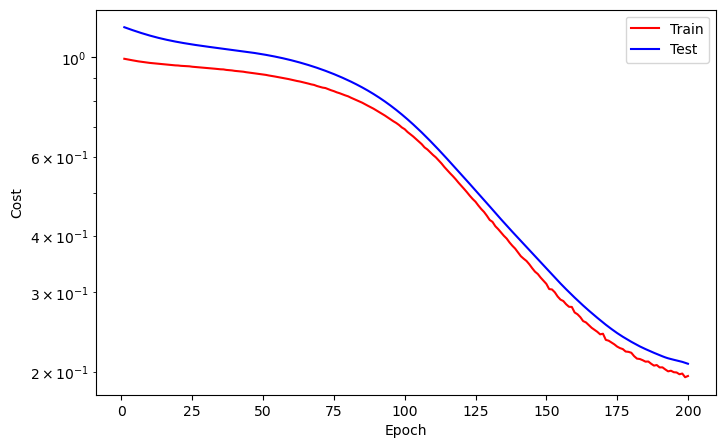

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 0.1961 | Test_cost  = 0.2073 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 0.1944 | Test_cost  = 0.2064 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 0.1937 | Test_cost  = 0.2057 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 0.1923 | Test_cost  = 0.2050 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 0.1918 | Test_cost  = 0.2044 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 0.1923 | Test_cost  = 0.2039 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   207
Train_cost  = 0.1904 | Test_cost  = 0.2034 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   208
Train_cost  = 0.1900 | Test_cost  = 0.2029 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   209
Train_cost  = 0.1894 | Test_cost  = 0.2024 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   210
Train_cost  = 0.1896 | Test_cost  = 0.2019 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   211
Train_cost  = 0.1885 | Test_cost  = 0.2013 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   212
Train_cost  = 0.1884 | Test_cost  = 0.2006 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   213
Train_cost  = 0.1863 | Test_cost  = 0.1999 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   214
Train_cost  = 0.1866 | Test_cost  = 0.1993 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   215
Train_cost  = 0.1859 | Test_cost  = 0.1987 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   216
Train_cost  = 0.1845 | Test_cost  = 0.1981 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   217
Train_cost  = 0.1849 | Test_cost  = 0.1977 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   218
Train_cost  = 0.1836 | Test_cost  = 0.1973 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   219
Train_cost  = 0.1850 | Test_cost  = 0.1970 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   220
Train_cost  = 0.1844 | Test_cost  = 0.1967 | 


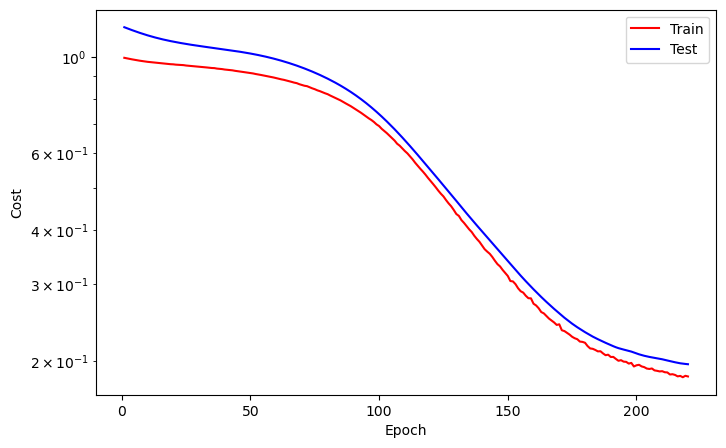

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   221
Train_cost  = 0.1840 | Test_cost  = 0.1963 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   222
Train_cost  = 0.1829 | Test_cost  = 0.1958 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   223
Train_cost  = 0.1823 | Test_cost  = 0.1955 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   224
Train_cost  = 0.1818 | Test_cost  = 0.1951 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   225
Train_cost  = 0.1816 | Test_cost  = 0.1945 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   226
Train_cost  = 0.1809 | Test_cost  = 0.1940 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   227
Train_cost  = 0.1811 | Test_cost  = 0.1936 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   228
Train_cost  = 0.1807 | Test_cost  = 0.1932 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   229
Train_cost  = 0.1797 | Test_cost  = 0.1928 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   230
Train_cost  = 0.1802 | Test_cost  = 0.1925 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   231
Train_cost  = 0.1798 | Test_cost  = 0.1922 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   232
Train_cost  = 0.1786 | Test_cost  = 0.1919 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   233
Train_cost  = 0.1781 | Test_cost  = 0.1916 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   234
Train_cost  = 0.1775 | Test_cost  = 0.1913 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   235
Train_cost  = 0.1776 | Test_cost  = 0.1910 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   236
Train_cost  = 0.1772 | Test_cost  = 0.1906 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   237
Train_cost  = 0.1770 | Test_cost  = 0.1902 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   238
Train_cost  = 0.1763 | Test_cost  = 0.1897 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   239
Train_cost  = 0.1759 | Test_cost  = 0.1892 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   240
Train_cost  = 0.1759 | Test_cost  = 0.1888 | 


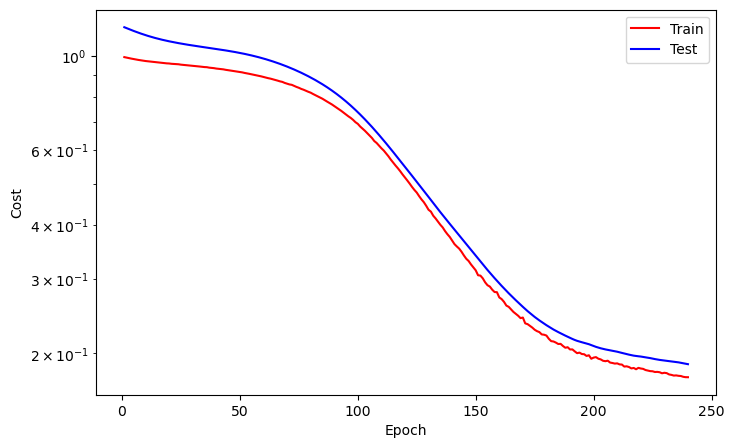

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   241
Train_cost  = 0.1751 | Test_cost  = 0.1884 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   242
Train_cost  = 0.1751 | Test_cost  = 0.1880 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   243
Train_cost  = 0.1743 | Test_cost  = 0.1876 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   244
Train_cost  = 0.1739 | Test_cost  = 0.1873 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   245
Train_cost  = 0.1739 | Test_cost  = 0.1870 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   246
Train_cost  = 0.1736 | Test_cost  = 0.1868 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   247
Train_cost  = 0.1738 | Test_cost  = 0.1866 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   248
Train_cost  = 0.1727 | Test_cost  = 0.1865 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   249
Train_cost  = 0.1731 | Test_cost  = 0.1862 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   250
Train_cost  = 0.1717 | Test_cost  = 0.1859 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   251
Train_cost  = 0.1730 | Test_cost  = 0.1856 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   252
Train_cost  = 0.1717 | Test_cost  = 0.1852 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   253
Train_cost  = 0.1710 | Test_cost  = 0.1847 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   254
Train_cost  = 0.1707 | Test_cost  = 0.1843 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   255
Train_cost  = 0.1704 | Test_cost  = 0.1838 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   256
Train_cost  = 0.1707 | Test_cost  = 0.1834 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   257
Train_cost  = 0.1704 | Test_cost  = 0.1830 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   258
Train_cost  = 0.1699 | Test_cost  = 0.1827 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   259
Train_cost  = 0.1702 | Test_cost  = 0.1825 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   260
Train_cost  = 0.1693 | Test_cost  = 0.1823 | 


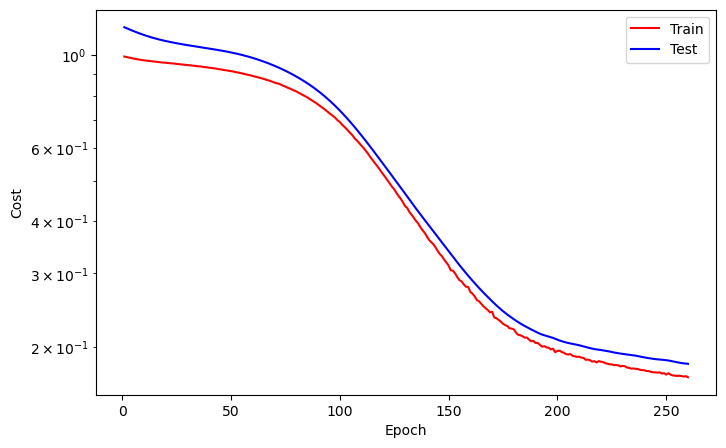

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   261
Train_cost  = 0.1690 | Test_cost  = 0.1821 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   262
Train_cost  = 0.1687 | Test_cost  = 0.1818 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   263
Train_cost  = 0.1686 | Test_cost  = 0.1815 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   264
Train_cost  = 0.1688 | Test_cost  = 0.1811 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   265
Train_cost  = 0.1687 | Test_cost  = 0.1807 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   266
Train_cost  = 0.1701 | Test_cost  = 0.1805 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   267
Train_cost  = 0.1683 | Test_cost  = 0.1803 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   268
Train_cost  = 0.1669 | Test_cost  = 0.1800 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   269
Train_cost  = 0.1662 | Test_cost  = 0.1798 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   270
Train_cost  = 0.1662 | Test_cost  = 0.1795 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   271
Train_cost  = 0.1663 | Test_cost  = 0.1791 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   272
Train_cost  = 0.1649 | Test_cost  = 0.1788 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   273
Train_cost  = 0.1616 | Test_cost  = 0.1784 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   274
Train_cost  = 0.1658 | Test_cost  = 0.1779 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   275
Train_cost  = 0.1650 | Test_cost  = 0.1774 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   276
Train_cost  = 0.1652 | Test_cost  = 0.1769 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   277
Train_cost  = 0.1640 | Test_cost  = 0.1763 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   278
Train_cost  = 0.1645 | Test_cost  = 0.1759 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   279
Train_cost  = 0.1639 | Test_cost  = 0.1757 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   280
Train_cost  = 0.1640 | Test_cost  = 0.1755 | 


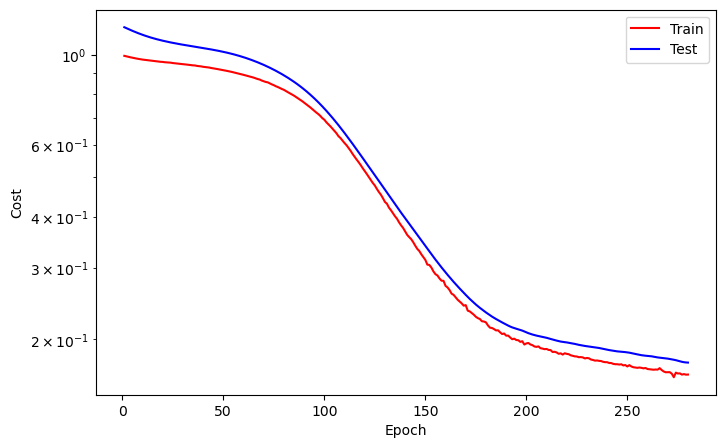

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   281
Train_cost  = 0.1642 | Test_cost  = 0.1756 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1755


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   282
Train_cost  = 0.1634 | Test_cost  = 0.1758 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1755


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   283
Train_cost  = 0.1623 | Test_cost  = 0.1759 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1755


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   284
Train_cost  = 0.1627 | Test_cost  = 0.1759 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1755


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   285
Train_cost  = 0.1621 | Test_cost  = 0.1758 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1755
==> Execute Early Stopping at epoch: 285 | Best test_cost: 0.1755
==> Best model is saved at model/gru


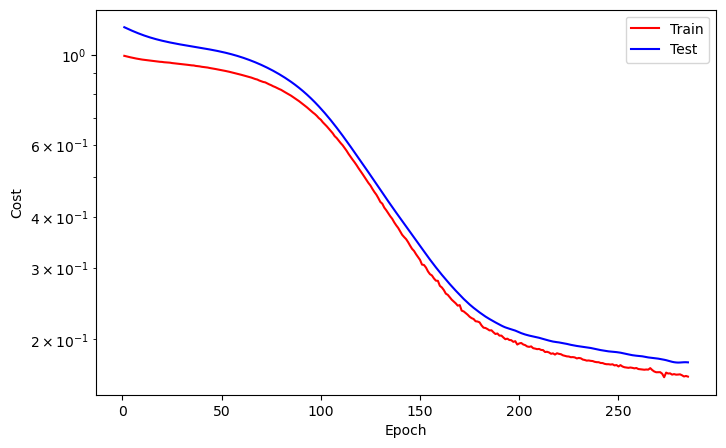

In [46]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

##  Prediction

In [47]:
train_forecast_set = TimeSeriesDataset(ts_train, "united_states_all_sectors", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "united_states_all_sectors", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (203, 1, 1)
Note: last 0 data excluded

(N, S, F): (50, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

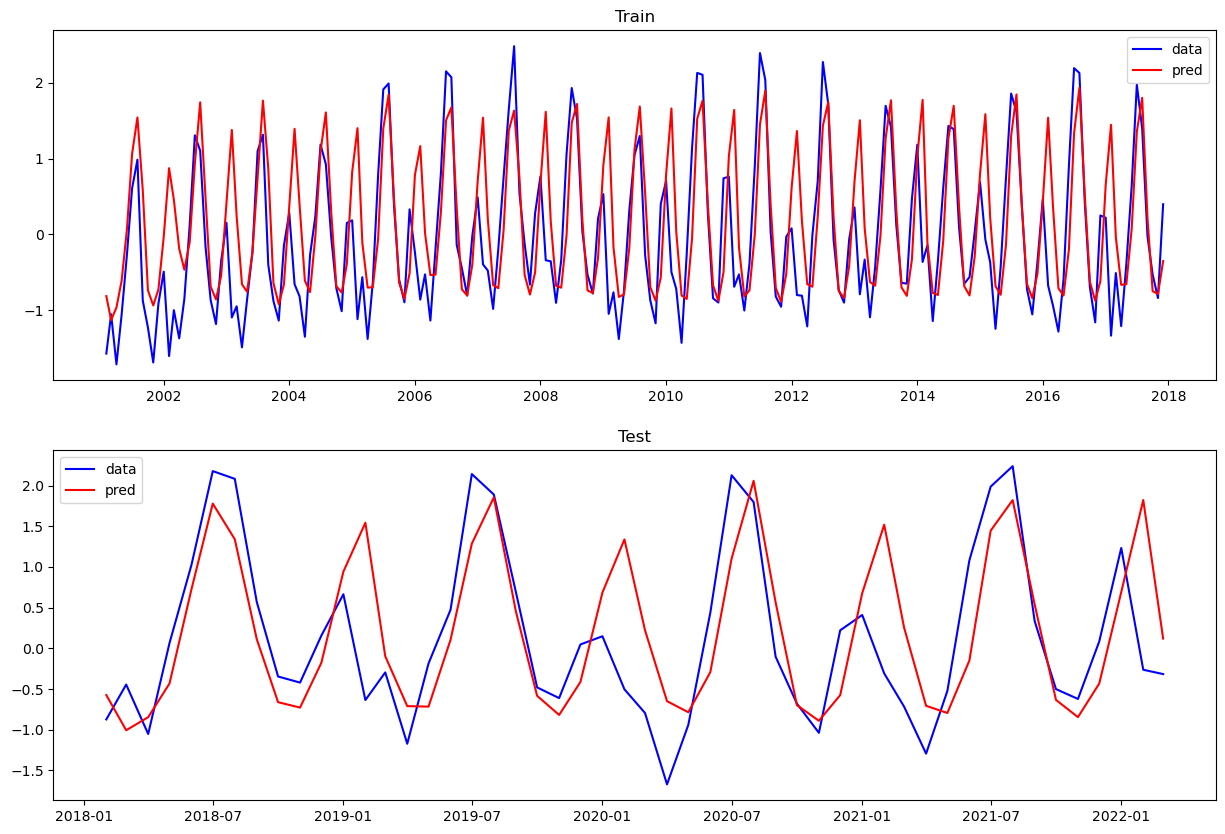

In [48]:
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'Test')

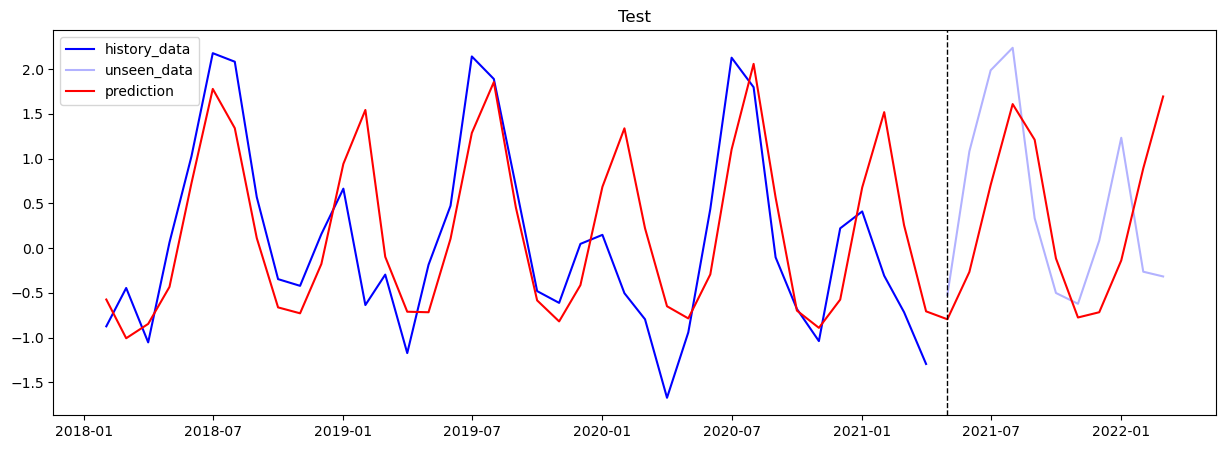

In [49]:
plt.figure(figsize=(15, 5))

pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')